<a href="https://colab.research.google.com/github/nabilLearns/Deeply-Supervised-Nets/blob/master/DSN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get required modules

In [ ]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip --quiet install wget

In [ ]:
#import os
#os.path.join(os.getcwd()
print(os.getcwd())
print(os.path.join(os.getcwd(), 'DateData'))

/home/nabil/Documents/Code/Data_Classification
/home/nabil/Documents/Code/Data_Classification/DateData


## Download Dataset

In [ ]:
# Download dataset in an .arff final into current working directory

import wget, requests, io, os, shutil
from zipfile import ZipFile

data_url = "https://www.muratkoklu.com/datasets/vtdhnd06.php"
req = requests.get(data_url)
zip_file = ZipFile(io.BytesIO(req.content))
path = os.path.join(os.getcwd())
zip_file.extractall(path)

shutil.move(os.path.join(os.getcwd(),'Date_Fruit_Datasets/Date_Fruit_Datasets.arff'), os.path.join(os.getcwd(), 'Date_Fruit_Datasets.arff'))
shutil.rmtree(os.path.join(os.getcwd(),'Date_Fruit_Datasets'))


In [ ]:
# Python script that converts .arff to .csv (not mine)
# Source: https://github.com/haloboy777/arfftocsv/blob/master/arffToCsv.py

#########################################
# Project   : ARFF to CSV converter     #
# Created   : 10/01/17 11:08:06         #
# Author    : haloboy777                #
# Licence   : MIT                       #
#########################################

# Importing library
import os

# Getting all the arff files from the current directory
files = [arff for arff in os.listdir('.') if arff.endswith(".arff")]
print(files)

# Function for converting arff list to csv list
def toCsv(text):
    data = False
    header = ""
    new_content = []
    for line in text:
        if not data:
            if "@ATTRIBUTE" in line or "@attribute" in line:
                attributes = line.split()
                if("@attribute" in line):
                    attri_case = "@attribute"
                else:
                    attri_case = "@ATTRIBUTE"
                column_name = attributes[attributes.index(attri_case) + 1]
                header = header + column_name + ","
            elif "@DATA" in line or "@data" in line:
                data = True
                header = header[:-1]
                header += '\n'
                new_content.append(header)
        else:
            new_content.append(line)
    return new_content


# Main loop for reading and writing files
for file in files:
    with open(file, "r") as inFile:
        content = inFile.readlines()
        name, ext = os.path.splitext(inFile.name)
        new = toCsv(content)
        with open(name + ".csv", "w") as outFile:
            outFile.writelines(new)

['Date_Fruit_Datasets.arff']


## Preprocess Data

In [ ]:
data = pd.read_csv("Date_Fruit_Datasets.csv")
print(data.head())

     AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  \
0  422163   2378.908    837.8484    645.6693        0.6373  733.1539   
1  338136   2085.144    723.8198    595.2073        0.5690  656.1464   
2  526843   2647.394    940.7379    715.3638        0.6494  819.0222   
3  416063   2351.210    827.9804    645.2988        0.6266  727.8378   
4  347562   2160.354    763.9877    582.8359        0.6465  665.2291   

   SOLIDITY  CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  KurtosisRR  KurtosisRG  \
0    0.9947       424428  0.7831        1.2976  ...      3.2370      2.9574   
1    0.9974       339014  0.7795        1.2161  ...      2.6228      2.6350   
2    0.9962       528876  0.7657        1.3150  ...      3.7516      3.8611   
3    0.9948       418255  0.7759        1.2831  ...      5.0401      8.6136   
4    0.9908       350797  0.7569        1.3108  ...      2.7016      2.9761   

   KurtosisRB    EntropyRR    EntropyRG    EntropyRB  ALLdaub4RR  ALLdaub4RG  \
0      4.228

### Generate train/val/test data splits

In [ ]:
# Generate train/val/test data splits

#print(data.info())
#print(data['Class'].unique())

data['Class'] = data['Class'].astype('category').cat.codes + 1
print(data['Class'].unique())
train, val, test = {}, {}, {}
for date_type in data['Class'].unique(): #['DOKOL']

    num_examples = data[data['Class'] == date_type].shape[0]
    data[data['Class'] == date_type] = data[data['Class'] == date_type].sample(frac=1, random_state=42)

    train[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[0:int(num_examples*0.8)]#.values
    val[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.8):int(num_examples*0.9)]#.values
    test[date_type] = data[data['Class'] == date_type].reset_index().drop(columns=['index']).iloc[int(num_examples*0.9):]#.values

    print(type(train[date_type]), train[date_type].shape)

#print(len(train))
train, val, test = [pd.concat(split).sample(frac=1, random_state=1).reset_index(drop=True) for split in [train, val, test]]

[1 2 3 4 5 6 7]
<class 'pandas.core.frame.DataFrame'> (52, 35)
<class 'pandas.core.frame.DataFrame'> (78, 35)
<class 'pandas.core.frame.DataFrame'> (163, 35)
<class 'pandas.core.frame.DataFrame'> (57, 35)
<class 'pandas.core.frame.DataFrame'> (132, 35)
<class 'pandas.core.frame.DataFrame'> (159, 35)
<class 'pandas.core.frame.DataFrame'> (75, 35)
7


### Get data and label tensors from each dataframe split

In [ ]:
# Get data and label tensors from each split dataframe

X_train = torch.Tensor(train.values[:,:-1])
Y_train = torch.Tensor(train.values[:,-1])

X_val = torch.Tensor(val.values[:,:-1])
Y_val = torch.Tensor(val.values[:,-1])

X_test = torch.Tensor(test.values[:,:-1])
Y_test = torch.Tensor(test.values[:,-1])

In [ ]:
X_train.shape

torch.Size([716, 34])

## Define Model Architecture and Loss

In [ ]:
# define model
torch.manual_seed(0)

def mlpconv(c_in, c_out, ks, stride):
    """
    Part of an implementation of Network-in-Network. May use this in the future on a CV dataset.
    """
    conv1 = nn.Conv2d(c_in, c_out, ks, stride)
    conv2 = nn.Conv2d(c_out, c_out, ks=1)
    conv3 = nn.Conv2d(c_out, c_out, ks=1)
    layers = [conv1, nn.ReLU(), conv2, nn.ReLU(), conv3, nn.ReLU()]
    return nn.Sequential(*layers)


class Network(nn.Module):
    def __init__(self, n_in=34, n_hidden=5, n_classes=7):#, ks, stride):
        super(Network, self).__init__()
        self.mapping1 = nn.Linear(n_in, n_hidden)
        self.mapping2 = nn.Linear(n_hidden, n_hidden)
        self.mapping3 = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        f_map1 = self.relu(self.mapping1(x))
        f_map2 = self.relu(self.mapping2(f_map1))
        f_map3 = self.mapping3(f_map2)

        #svm_1 = torch.randn(f_map1.shape[1])
        #svm_2 = torch.randn(f_map2.shape[1])
        #svm_3 = torch.randn(f_map3.shape[1])

        svm_1 = torch.empty(f_map1.shape[1])
        nn.init.uniform_(svm_1, -0.001, 0.001)

        svm_2 = torch.empty(f_map2.shape[1])
        nn.init.uniform_(svm_2, -0.001, 0.001)

        svm_3 = torch.empty(f_map3.shape[1])
        nn.init.uniform_(svm_3, -0.001, 0.001)

        return [f_map1, f_map2, f_map3, svm_1, svm_2, svm_3]


def companion_loss(f_map, svm_w, t_labels, n_labels=7):
    """
    Implements L2-SVM companion objective loss described by equations (4) and (5) of the "Deeply Supervised Nets" paper ([Gallagher et. al, 2014])

    parameters
    ----------
    f_map: of shape (BATCH_SIZE x NUM_FEATURES)
    svm_w: svm weights
    t_labels: vector of labels
    """

    loss = 0
    all_labels = torch.arange(n_labels) + 1

    f_labels = [all_labels[all_labels != t_labels[i]] for i in range(len(t_labels))] # f_labels.shape = (# examples, 6), each row has labels != t_label
    f_labels = torch.stack(f_labels)

    #print(f_map.shape, svm_w.shape, (f_map@svm_w).shape)
    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # torch.Size([716, 1])

    # < w^(m), (Z^(m), y) >
    true_label_svm = svm_pred * torch.unsqueeze(t_labels,dim=0).T # torch.Size([716, 1])
    
    # < w^(m), (Z^(m), y_k) > for all k
    f_labels_svm = svm_pred * f_labels # torch.Size([716, 6])

    #print(svm_pred.shape, true_label_svm.shape, f_labels_svm.shape, t_labels.shape)
    loss = torch.sum(torch.nn.functional.relu(1 - (true_label_svm - f_labels_svm)))**2
    
    return loss #* 10e-5

#global_loss = lambda data: torch.sum([companion_loss(f_map) for f_map in Network(data)])
def global_loss(model_out: list, Y, alphas: list, gamma = 0.3):
    """
    Return overall combined objective function as specified in eq. (3) of [Gallagher et. al, 2014]
    
    parameters
    ----------
    model_out: [f_map1, f_map2, f_map3, svm1, svm2, svm3]
    alphas: list of alpha values (see eq. (3), and pg. 4 of [Gallagher et. al, 2014])
    gamma: see pg. 4 of [Gallagher et. al, 2014]
    """

    n_layers = len(model_out) // 2
    companion_losses = [companion_loss(model_out[i], model_out[i+n_layers], Y) for i in range(n_layers)]
    f_layer_loss = torch.norm(model_out[-1])**2 + companion_losses[-1]
    modified_companion_losses = [alphas[i] * torch.nn.functional.relu(torch.norm(model_out[i])**2 + companion_losses[i] - gamma) for i in range(n_layers - 1)]
    global_loss = f_layer_loss + sum(modified_companion_losses)
    
    #print("norms: ", torch.norm(model_out[-1]), torch.norm(model_out[-2]))
    return global_loss
    
model = Network()

## Train

In [ ]:
def train(num_epochs = 100):
    opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    epoch_losses = []

    alphas = [1, 1, 1]
    for epoch in range(num_epochs):
        if epoch % (int)(num_epochs * 0.1) == 0:
            print(f"EPOCH {epoch}")

        alphas = [a * 0.1 * (1 - epoch / num_epochs) for a in alphas]
        opt.zero_grad()
        L = global_loss(model(X_train), Y_train, alphas)
        L.backward()
        opt.step()

        epoch_losses.append(L.item())
        #print(L.item())
    
    plt.plot(epoch_losses[1:])
    plt.title("Train Set Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()
    
    return epoch_losses

EPOCH 0
EPOCH 10
EPOCH 20
EPOCH 30
EPOCH 40
EPOCH 50
EPOCH 60
EPOCH 70
EPOCH 80
EPOCH 90


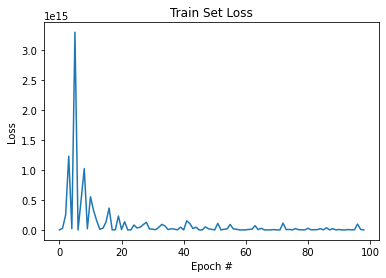

[7.034716067644983e+21,
 140412207104.0,
 25985097400320.0,
 247469774471168.0,
 1231290753875968.0,
 19216176513024.0,
 3299276302057472.0,
 186282098688.0,
 508074666229760.0,
 1022005453258752.0,
 18992003547136.0,
 553202927796224.0,
 323296381894656.0,
 154406171443200.0,
 10394561150976.0,
 28628085637120.0,
 130579253166080.0,
 364384186531840.0,
 1779630997504.0,
 2379412668416.0,
 231071589335040.0,
 6887480754176.0,
 136027435958272.0,
 380220538880.0,
 27310723072.0,
 81654047571968.0,
 31827521699840.0,
 45467509456896.0,
 88527773630464.0,
 126918204588032.0,
 14148656168960.0,
 14186411196416.0,
 2977339801600.0,
 45004588318720.0,
 92299518279680.0,
 65428307050496.0,
 4466791153664.0,
 20766217207808.0,
 12867925442560.0,
 1860400840704.0,
 46195145703424.0,
 135517077504.0,
 151802230079488.0,
 105547101634560.0,
 22942740119552.0,
 45712410673152.0,
 114171084800.0,
 287210864640.0,
 51180180865024.0,
 18575941173248.0,
 9731542351872.0,
 14424399872.0,
 1096075821711

In [ ]:
train()

### Deprecated code for testing

In [ ]:
# Alternative ways we attempted to determine companion loss
    
"""
deprecated code -- alternate ways I tried calculating loss
i = 0
for row in f_labels: # i.e. row = torch.Tensor([0, 2, 3, 4, 5, 6])
    i += 1
    if i % 10 == 0:
        print(i)
    for f_label in row:
        # < w^(m), (Z^(m), y_k) >
        f_label_svm = (f_map @ svm_w) * f_label

        # max(0, 1 - (true_label_svm - f_label_svm))**2
        loss += sum(torch.nn.functional.relu(1 - (true_label_svm - f_label_svm))**2)
"""

"""
for row in f_labels:
    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # shape = (# examples, 1)
    row = torch.unsqueeze(row, dim=0) # shape = (1, 6)
    f_label_svms = svm_pred.long() @ row
    loss += torch.sum(torch.nn.functional.relu(1 - (true_label_svm.T - f_label_svms))**2)
return loss
    #true_label_svm = torch.unsqueeze((f_map @ svm_w) * t_labels, dim=0).T # torch.Size([716, 1]) 
"""


'\nfor row in f_labels:\n    svm_pred = torch.unsqueeze(f_map @ svm_w, dim=0).T # shape = (# examples, 1)\n    row = torch.unsqueeze(row, dim=0) # shape = (1, 6)\n    f_label_svms = svm_pred.long() @ row\n    loss += torch.sum(torch.nn.functional.relu(1 - (true_label_svm.T - f_label_svms))**2)\nreturn loss\n    #true_label_svm = torch.unsqueeze((f_map @ svm_w) * t_labels, dim=0).T # torch.Size([716, 1]) \n'

In [ ]:
# test loss

f1, f2, f3, svm1, svm2, svm3 = model(X_train)

loss_1 = companion_loss(f1, svm1, Y_train)
loss_2 = companion_loss(f2, svm2, Y_train)
loss_3 = companion_loss(f3, svm3, Y_train)

global_loss(model(X_train), Y_train, alphas=[0.1, 0.2, 0.3])

norms:  tensor(0.0018) tensor(0.0015)


tensor(7.6783e+09, grad_fn=<AddBackward0>)

In [ ]:
a = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 10])
a = torch.unsqueeze(a, dim=0)

true = torch.ones(a.shape)

f = torch.Tensor([0, -1, 2])
f = torch.unsqueeze(f, dim=0)

print(a.shape, f.shape, true.shape)

m = (a.T @ f)

print(m, m.shape)

print(1 - (true.T - m))

sum(torch.nn.functional.relu(1 - (true.T - m))**2)

torch.Size([1, 9]) torch.Size([1, 3]) torch.Size([1, 9])
tensor([[  0.,  -1.,   2.],
        [  0.,  -2.,   4.],
        [  0.,  -3.,   6.],
        [  0.,  -4.,   8.],
        [  0.,  -5.,  10.],
        [  0.,  -6.,  12.],
        [  0.,  -7.,  14.],
        [  0.,  -8.,  16.],
        [  0., -10.,  20.]]) torch.Size([9, 3])
tensor([[  0.,  -1.,   2.],
        [  0.,  -2.,   4.],
        [  0.,  -3.,   6.],
        [  0.,  -4.,   8.],
        [  0.,  -5.,  10.],
        [  0.,  -6.,  12.],
        [  0.,  -7.,  14.],
        [  0.,  -8.,  16.],
        [  0., -10.,  20.]])


tensor([   0.,    0., 1216.])

In [ ]:
print(torch.norm(a))
print(a)

tensor(17.4356)
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10.]])


In [ ]:
j = torch.cat([a] * 3, dim=0) #.squeeze(dim=1)

print(a.T.shape, j.T.shape)

print(a.T)
print(j.T)
print(a.T * j.T)

torch.Size([9, 1]) torch.Size([9, 3])
tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [10.]])
tensor([[ 1.,  1.,  1.],
        [ 2.,  2.,  2.],
        [ 3.,  3.,  3.],
        [ 4.,  4.,  4.],
        [ 5.,  5.,  5.],
        [ 6.,  6.,  6.],
        [ 7.,  7.,  7.],
        [ 8.,  8.,  8.],
        [10., 10., 10.]])
tensor([[  1.,   1.,   1.],
        [  4.,   4.,   4.],
        [  9.,   9.,   9.],
        [ 16.,  16.,  16.],
        [ 25.,  25.,  25.],
        [ 36.,  36.,  36.],
        [ 49.,  49.,  49.],
        [ 64.,  64.,  64.],
        [100., 100., 100.]])


In [ ]:
svm_w = torch.randn(f1.shape[1])

g = f1 @ svm_w
g = torch.unsqueeze(g, dim=0).T

print(torch.unsqueeze(torch.Tensor([1, 2, 3]), dim=0).shape)

g @ torch.unsqueeze(torch.Tensor([1, 2]), dim=0)

torch.Size([1, 3])


tensor([[-3.5995e+09, -7.1990e+09],
        [-4.6115e+09, -9.2229e+09],
        [-1.0095e+10, -2.0191e+10],
        ...,
        [-3.0495e+09, -6.0990e+09],
        [-3.0662e+09, -6.1324e+09],
        [-4.7045e+09, -9.4091e+09]], grad_fn=<MmBackward0>)

In [ ]:
# testing 
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
print(input)

test = Network()
inp = torch.randn(9,34)
a, b, c, d, e, f = test(inp)
print(a.shape, b.shape, c.shape)

#print(nn.init_kaiming_normal_(torch.empty((b.shape[1]))).shape)
print(a, "\n", torch.rand(5))
print(a @ torch.randn(5))


tensor([[ 0.2729,  0.6006, -1.0398,  ..., -1.3764, -0.0181,  1.2899],
        [-0.6619,  1.7155,  0.6828,  ...,  0.9750,  1.2621,  0.8714],
        [-1.2249,  0.1158,  0.3892,  ..., -0.3131, -2.3804,  1.4633],
        ...,
        [-1.5346, -0.2088, -0.1406,  ..., -1.7168, -1.1358,  0.0471],
        [ 0.8725,  0.7688, -0.9170,  ..., -0.0053,  0.7168,  0.7663],
        [ 1.4065,  0.4206,  0.5572,  ...,  0.0384,  1.0939, -1.8568]])
torch.Size([9, 5]) torch.Size([9, 5]) torch.Size([9, 7])
tensor([[5.5009e-01, 0.0000e+00, 0.0000e+00, 2.4173e+00, 8.9588e-01],
        [9.5940e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1044e-03],
        [0.0000e+00, 4.6178e-01, 3.1330e-01, 7.4526e-01, 6.1229e-01],
        [1.3101e+00, 5.0964e-02, 0.0000e+00, 7.9191e-01, 8.7336e-01],
        [0.0000e+00, 7.7665e-01, 6.6595e-01, 0.0000e+00, 5.7977e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9455e-01],
        [2.5700e-02, 0.0000e+00, 0.0000e+00, 3.9999e-02, 0.0000e+00],
        [4.6324e-01